<a href="https://colab.research.google.com/github/vivekp12/dst-group-project-2/blob/main/VivekP/03-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

Having chosen a dataset to use, we now do some exploration to try to understand it. In this document, we perform exploratory data analysis on the [brain tumour MRI dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data) [1]. The document is structured as follows.

**Table of Contents**
- [1. Requirements](#1-requirements)
    - [1.1 Loading the Dataset](#11-loading-the-dataset)
    - [1.2 Checking for Duplicates](#12-checking-for-duplicates)
- [2. Exploratory Data Analysis](#2-exploratory-data-analysis)
    - [2.1 Class Distributions](#21-class-distributions)
    - [2.2. Viewing the Images](#22-viewing-the-images)
    - [2.3. Preprocessing Images](#23-preprocessing-images)
    - [2.4. Edge Detection](#34-edge-detection)
    - [2.5. Dimensionality Reduction](#35-dimensionality-reduction)
- [3. Conclusion](#4-conclusion)
- [4. References](#5-references)


# 1. Requirements

We first load the requirements.

In [30]:
import sys
import subprocess

# List of required packages
required_packages = [
    'kagglehub', 'os', 'hashlib', 'numpy', 'pandas', 'matplotlib', 'seaborn',
    'PIL', 'pathlib', 'tqdm', 'cv2', 'imutils', 'sklearn', 'skimage'
]

# Install missing packages
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Now import the packages
import kagglehub
import os
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import cv2
import imutils
from sklearn.decomposition import PCA
from skimage import feature
from skimage.measure import shannon_entropy

# 1.1.1 Loading the Dataset
We next load the dataset. This dataset is downloaded from Kaggle.

In [31]:
# Instructions taken from https://www.kaggle.com/docs/api#authentication

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


# 1.1.2 Dataset Description

The [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) page contains information on the source of this dataset. In particular, this dataset is a combination of these datasets:
- [figshare](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427)
- [SARTAJ dataset](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri)
- [Br35H](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=no)

This dataset contains 7023 images of human brain magnetic resonance imaging (MRI) images. MRI is a process to visualise internal structures of the body [25]. In our case, MRI is being used to detect tumours, which are abnormal masses of cells in the body [26]. The images in the dataset are categorised into 4 classes:
- glioma,
- meningioma, 
- pituitary,
- no tumor.

The first three classes listed above are the tumor classes. The "no tumor" class images were taken from the Br35H dataset. This dataset was interesting for us since identifying brain tumours is highly important. The cranium, which encloses the brain, is rigid and any growth inside such a restricted space can lead to pressure inside the skull. This can lead to brain damage and can be life-threatening (description adapted from [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) page [1]).

In this document, we perform EDA to understand the dataset. We will then apply the Convolutional Neural Network (CNN) for the classification and detection of tumors as it is an apt tool for this task [1, 27]. 

# 1.2 Checking for Duplicates

The following Kaggle [discussion](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/discussion/482896) suggests the presence of duplicate images in the dataset. We use their provided code [2] to check for duplicates.

In [32]:
# Code taken from https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/discussion/482896
## Additional comments added

# Define the root project directory and class labels based on the folder structure in the dataset
PROJECT_DIR = path  # Set the main directory path for your dataset
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']  # Adjust labels to match your dataset's folder names

# Function to compute MD5 hash of a file
# This hash will be used to identify duplicate images based on file content
def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()  # Returns a unique hash for each file

# Function to list all files in the specified dataset folders, organized by label
# The function fills the hash_dict dictionary with file paths keyed by hash value
def list_files(hash_dict):
    # Loop through each data type and label (e.g., 'Training' and 'Testing' sets)
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            # Construct the path for each label in the dataset
            folder_path = os.path.join(PROJECT_DIR, 'data', 'raw', data_type, label)
            # Walk through each file in the directory
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):  # Check if file is a .jpg image
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)  # Compute hash to check for duplicates
                        # If the hash exists in the dictionary, append the new file path
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]  # Add new hash with file path list

# Function to remove duplicate files based on hash values stored in hash_dict
# This function will remove all but one file for each unique hash (duplicate image)
def remove_duplicates(hash_dict):
    duplicate_count = 0  # Counter for the number of duplicates removed
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:  # If more than one file has the same hash, they are duplicates
            # Keep the first file, remove subsequent files
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash : {hash_value}) : {file_path}")
                os.remove(file_path)  # Remove duplicate file
                duplicate_count += 1  # Increment the count
    print(f"Number of duplicates : {duplicate_count}")  # Output the number of duplicates removed

# Main execution block
# Initializes an empty dictionary to store hash values and associated file paths
# Calls list_files to populate the dictionary and remove_duplicates to clean up duplicates
if __name__ == '__main__':
    hash_dict = {}  # Dictionary to store unique file hashes with associated file paths
    list_files(hash_dict)  # Populate hash_dict with file paths organized by hash
    remove_duplicates(hash_dict)  # Remove duplicate images based on hash values

Number of duplicates : 0


The code works in the following way. It finds the so-called "hash" for each file, which is akin to the digital fingerprint of a file [23]. The hashing algorithm the script uses is called MD5 (Message Digest Algorithm 5) [24]. This creates a 128-bit hash from any data, whether it’s text, an image, or even an entire file. This fingerprint is unique to the content of the file, meaning even a tiny change in the data will produce a completely different hash. The MD5 hash is typically represented as a 32-character hexadecimal (base 16) string.

By calculating a hash for each image, the script can compare these fingerprints to check if two images are identical. The script walks through each folder (training and testing) and each label folder. For each image, it calculates a hash and then stores this hash in a dictionary (`hash_dict`). The dictionary has hash values as keys and a list of file paths as values, allowing the script to track which files share the same hash.

Once all files are indexed in hash_dict, the script checks for any hash keys that map to more than one file. If multiple files have the same hash, that means they’re identical in content, even if they might have different names. The script keeps the first occurrence of each file and removes any additional ones, effectively cleaning up duplicates from the dataset.

We see that the output shows that there were no duplicates.

We can now proceed with our exploratory data analysis.

# 2. Exploratory Data Analysis

# 2.1 Class Distributions

We begin by checking the class distributions in the training and test data.

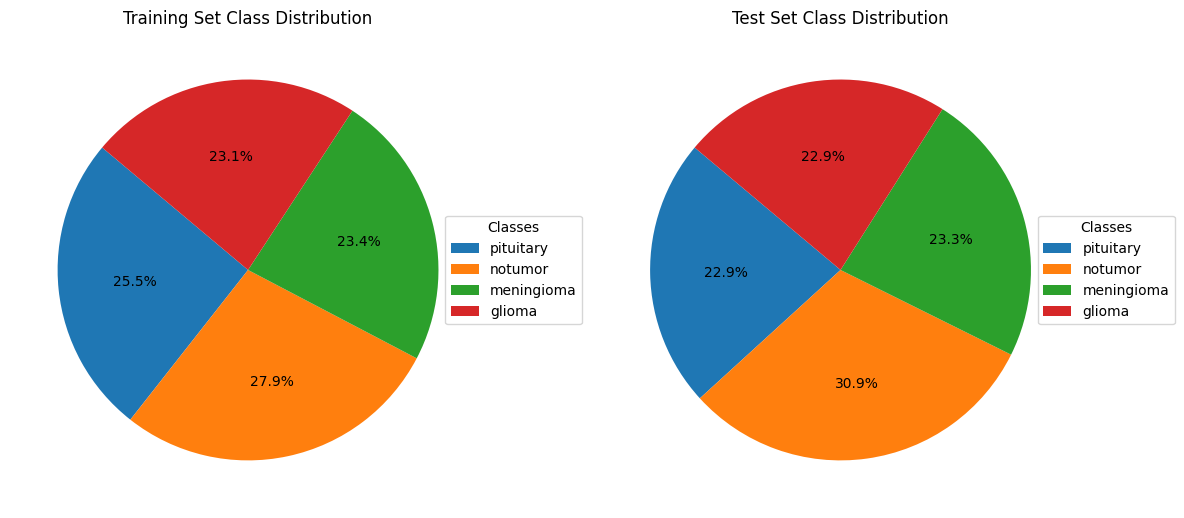

In [33]:
base_path = Path(path)
train_dir = base_path / "Training"
test_dir = base_path / "Testing"
labels = ['pituitary', 'notumor', 'meningioma', 'glioma']

def get_class_distribution(directory):
    class_counts = {}
    for label in labels:
        class_path = directory / label
        class_counts[label] = len(list(class_path.glob('*.jpg')))  # assuming images are in .jpg format
    return class_counts

train_class_counts = get_class_distribution(train_dir)
test_class_counts = get_class_distribution(test_dir)

# Training Set Pie Chart with Legend
plt.figure(figsize=(12, 6))

# Training set distribution
plt.subplot(1, 2, 1)
plt.pie(train_class_counts.values(), autopct='%1.1f%%', startangle=140)
plt.title("Training Set Class Distribution")
plt.legend(train_class_counts.keys(), title="Classes", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))

# Test set distribution
plt.subplot(1, 2, 2)
plt.pie(test_class_counts.values(), autopct='%1.1f%%', startangle=140)
plt.title("Test Set Class Distribution")
plt.legend(test_class_counts.keys(), title="Classes", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))

plt.tight_layout()
plt.show()

We can see that there is no problem of imbalance, as the classes are approximately evenly split in the training and test data. This is great news as it means that we will not have to use any techniques for dealing with imbalanced data, such as SMOTE or AdaSyn [8].

# 2.2 Viewing the Images
We next view the actual images to understand what it looks like.

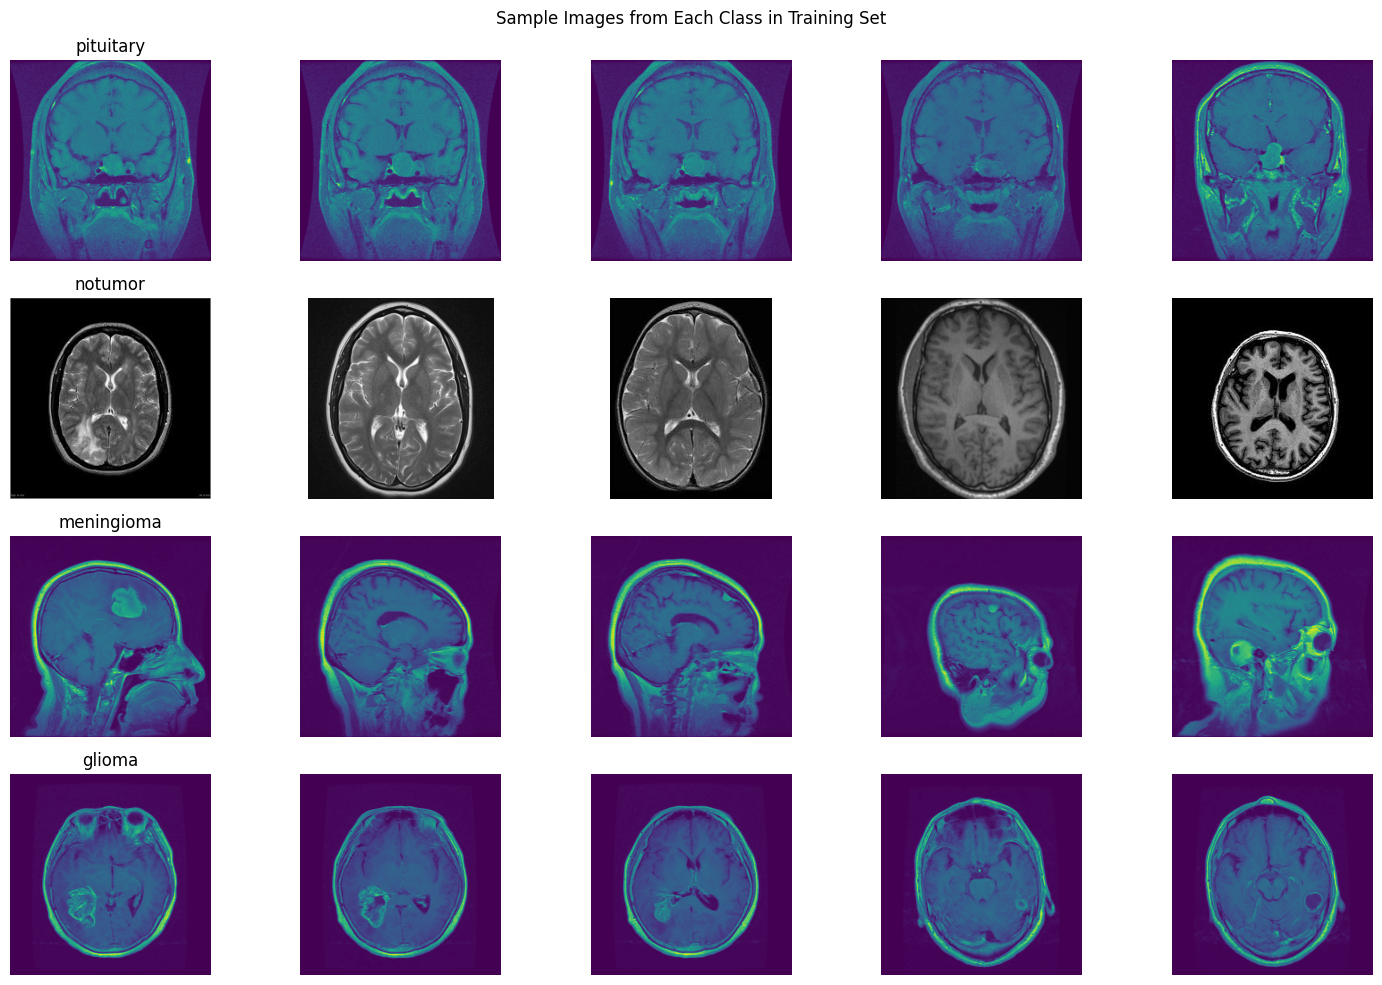

In [34]:
fig, axes = plt.subplots(len(labels), 5, figsize=(15, 10))
for idx, label in enumerate(labels):
    class_path = train_dir / label
    images = sorted(class_path.glob('*.jpg'))[1134:1139]  # Get 5 images from each class. Change the slicing e.g. [5:10] to [18:23] etc to see other images
    for j, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[idx, j].imshow(img)
        axes[idx, j].axis('off')
        if j == 0:
            axes[idx, j].set_title(label)
plt.suptitle('Sample Images from Each Class in Training Set')
plt.tight_layout()
plt.show()


We can see that this dataset seems to have some greyscale images and some color images. We can also see that there are different angles (front view, side view and back view) at which the MRI scans are taken, providing an insight into the information a model could use to make predictions. We can see some blobs, which are the tumours. This can be clearly seen in some images, such as the second image in the fourth row in this rendered notebook. To the untrained eye, it is however difficult to tell the difference between the different tumour types (meningioma, glioma, pituitary). There is some variability in the resolution of the images. For example, in the third row, the eye (black blob) has different levels of clarity.

**Note**: If you re-run the cell, the image output may be different. The list of images was sorted to prevent

## 2.2.1. A Discussion on Image Sizes
Looking at the images, and in particular the fourth column, we can see that the images are of different sizes. This is a problem for the model as the input layer for a neural network will typically only allow inputs of a fixed size [5]. While it may be possible to crop dynamically, this is an inefficient use of memory. To get around this issue, pre-processing is needed. Common methods include resizing (changing the dimensions of the image) and padding (adding a black space to uniformise the sizes). In this case, we prefer to use resizing. There are several advantages to doing this over padding [3]. We explain some of the advantages below:

1. Square images make it easier to use pre-trained models. Some state-of-the-art models, such as VGGNet or ResNet [9], have been trained on square images. By resizing our images to a square shape, we can leverage these pre-trained models more effectively, as the input dimensions of our images match those of the pre-trained models. This enables **transfer learning** [10], where the pre-trained models' learned features can be utilized to improve the accuracy and efficiency of our own CNN models.

2. Resizing images to a square shape helps to maintain consistency in the input dimensions across the dataset. The input layer will require inputs of a fixed size [5]. The so-called "tensors", used in a batch in training, are expected to be the same size [4]. While dynamic cropping is possible, it is an inefficient use of memory and is unadvisable here as we have a limited time and computational budget. By resizing all images to a square shape, we ensure that they have the same width and height, which simplifies the data handling and processing steps.

3. If a large part of the image is padded, the CNN will have to learn that the black part of the image is not relevant and does not help distinguishing between the classes, as there is no correlation between the pixels (a pixel is a picture element, i.e. one of the blocks making up the image) in the black part and belonging to a given class. This is not hard coded so the CNN will have to learn it, and this might probably take some epochs. This is feasible if we have time and computational power, but otherwise, resizing would be more feasible (explanation adapted from [3]).

# 2.3. Preprocessing Images

To perform the resizing, we run the following pre-processing code provided by the dataset creator. We annotate their code with additional comments and provide an explanation of what it does after the next code block.

In [35]:
### Code provided by dataset creator, taken from https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py
### Additional comments were added (indicated)
def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    # Convert the image to grayscale (required for thresholding)  ### Additional comment
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce noise and detail in the image  ### Additional comment
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Threshold the image to create a binary version, where regions of interest are white  ### Additional comment
    # Then perform erosions and dilations to remove small noise in the thresholded image  ### Additional comment
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours (outlines of shapes) in the thresholded image  ### Additional comment
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)  # Extract contours with imutils (for compatibility)  ### Additional comment

    # Select the largest contour  ### Additional comment
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points (left, right, top, bottom) of the largest contour  ### Additional comment
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Define the margin around the crop (0 pixels here, but adjustable if needed)  ### Additional comment
    ADD_PIXELS = 0

    # Crop the image to the bounding box defined by extreme points, then return the cropped image  ### Additional comment
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    return new_img

# Main processing block, executes when the script is run directly  ### Additional comment
if __name__ == "__main__":
    # Define directories for training and testing images  ### Additional comment
    training = train_dir
    testing = test_dir

    # List the folders (classes) inside training and testing directories  ### Additional comment
    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)

    # Define the target image size for resizing  ### Additional comment
    IMG_SIZE = 256

    # Loop over each class directory in the training data  ### Additional comment
    for dir in training_dir:
        # Define path to save cleaned images for the current class in training set  ### Additional comment
        save_path = 'cleaned/Training/'+ dir
        path = os.path.join(training, dir)  # Path to the class folder in the training directory  ### Additional comment
        image_dir = os.listdir(path)        # List images in the current class directory  ### Additional comment

        # Process each image within the class directory  ### Additional comment
        for img in image_dir:
            image = cv2.imread(os.path.join(path, img))  # Load the image
            new_img = crop_img(image)                    # Crop the image to focus on main region
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))  # Resize to standard dimensions

            # Create save directory if it doesn't exist  ### Additional comment
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # Save the processed image in the cleaned directory  ### Additional comment
            cv2.imwrite(save_path+'/'+img, new_img)

    # Repeat the same process for the testing data  ### Additional comment
    for dir in testing_dir:
        save_path = 'cleaned/Testing/'+ dir       # Define save path for testing images in cleaned folder
        path = os.path.join(testing, dir)         # Path to the class folder in the testing directory
        image_dir = os.listdir(path)              # List images in the current testing class directory

        for img in image_dir:
            image = cv2.imread(os.path.join(path, img))  # Load the image
            new_img = crop_img(image)                    # Crop to main region
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))  # Resize to 256x256 pixels

            # Create save directory if it doesn't exist
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # Save processed testing image
            cv2.imwrite(save_path+'/'+img, new_img)

This code standardizes all images to a fixed size. The `crop_img` function takes an image and applies the following preprocessing steps:

- Grayscale conversion and blurring: The image is converted to grayscale and blurred to reduce noise, making it easier to isolate the main region.
- Thresholding and noise removal: The blurred image is thresholded to create a binary (black-and-white) version. Then, small noise regions are removed with **erosion** and **dilation** operations (explained below).
- Cropping: The function crops the image to a 256 x 256 square.

Erosion and dilation are image processing techniques used to modify the shapes and sizes of objects. These operations are particularly helpful for tasks like joining disparate elements in an image and finding of intensity bumps or holes in an image [6]. We explain in more detail below:

1. Erosion removes pixels from the edges of objects in a binary image, effectively shrinking or "eroding" the white regions. This operation is helpful for removing small, isolated white noise in the background. Erosion is commonly used to remove small noise or separate objects that are close together.
2. Dilation does the opposite of erosion [7]; it adds pixels to the boundaries of objects, making white regions expand. This operation can "fill in" small holes or gaps within objects.

Erosion and dilation can be expressed using mathematical formulae but we refer the reader [6] for details, in the interest of brevity.

We checked that this process worked well by checking the image dimensions (see VivekP/03-EDA.ipynb). To allow us to see what the image processing did, we view the images again.

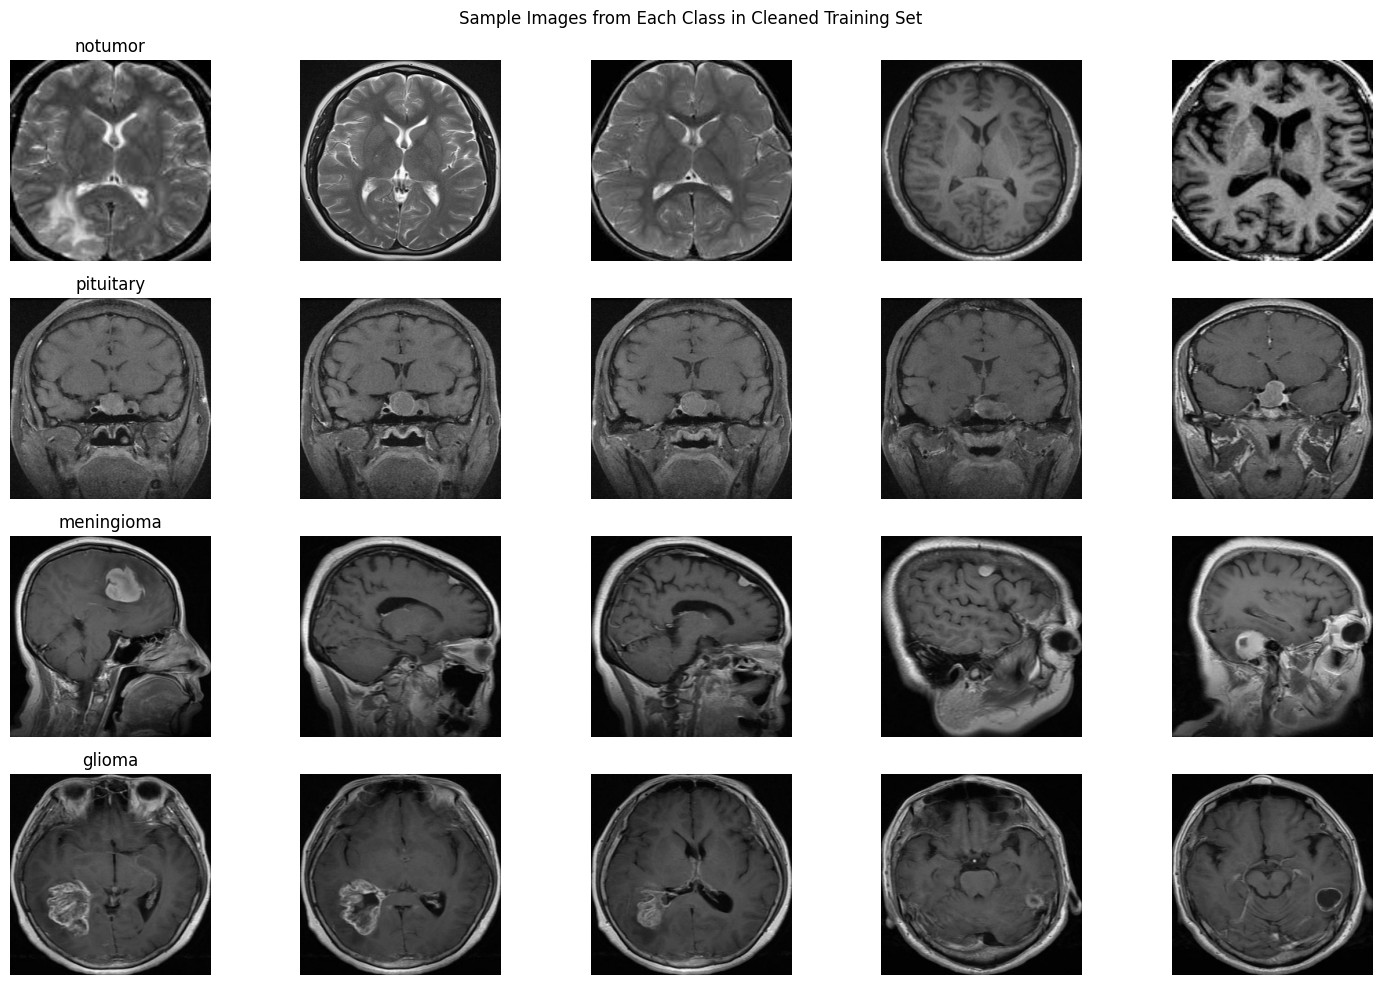

In [44]:
# Define the path to the cleaned training set
cleaned_train_dir = Path("cleaned/Training")

# Plot sample images from each class in cleaned training set
fig, axes = plt.subplots(len(labels), 5, figsize=(15, 10))
for idx, label in enumerate(labels):
    class_path = cleaned_train_dir / label
    images = sorted(class_path.glob('*.jpg'))[1134:1139]  # Get 5 images from each class. Change the slicing e.g. [5:10] to [18:23] etc to see other images
    for j, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[idx, j].imshow(img)
        axes[idx, j].axis('off')
        if j == 0:
            axes[idx, j].set_title(label)

plt.suptitle('Sample Images from Each Class in Cleaned Training Set')
plt.tight_layout()
plt.show()

We can see that there are no more colours and the images are now a consistent size. We can see that perhaps this has cut off some of the features of the image. This is clearly seen in the last image of the first row (glioma) in the rendered notebook. However, we note that key features are still present and the resizing process has not introduced artifacts (like pixelation or some other signs of image degradation).

While the cut off features can potentially cause problems in our models, due to computational limitations, we would have wanted to downsize the images to 32 x 32 (for example) to have a fit in reasonable time. Hence, we would have a loss of information anyway. Hence, due to computational limitations, we will accept this byproduct of the processing and not pursue this further.

# Further Analyses

We checked other quantities, such as the brightness, contrast and information content (measured using the entropy). Considering those 3 quantities, we found limited insight, only seeing that non-tumour images had qualitative differences to tumour images, but tumour images were somewhat similar to each other. We direct the reader to VivekP/03-EDA.ipynb for details.

We next present a way to check for artifacts and extract more information from the images using *Canny edge detection*.

# 2.4 Edge Detection

Canny edge detection [11] is an algorithm developed by John F. Canny in 1986 for identifying edges in images. It follows a multi-step process to detect sharp changes in intensity, which typically correspond to object boundaries. The mathematical details of how it works are given in VivekP/03-EDA.ipynb. Here, we only provide a summary.

Canny edge detection is effective because it combines noise reduction, gradient-based edge detection, and a double-threshold approach to distinguish between real edges and noise. This multi-step process results in clear, well-defined edges, as we will see in the output of the next code cell. We can implement it in Python simply by using `feature.canny` as follows. We run the algorithm on one sample from each class. We reran the cell multiple times to visualise the images and check for artifacts of pre-processing.

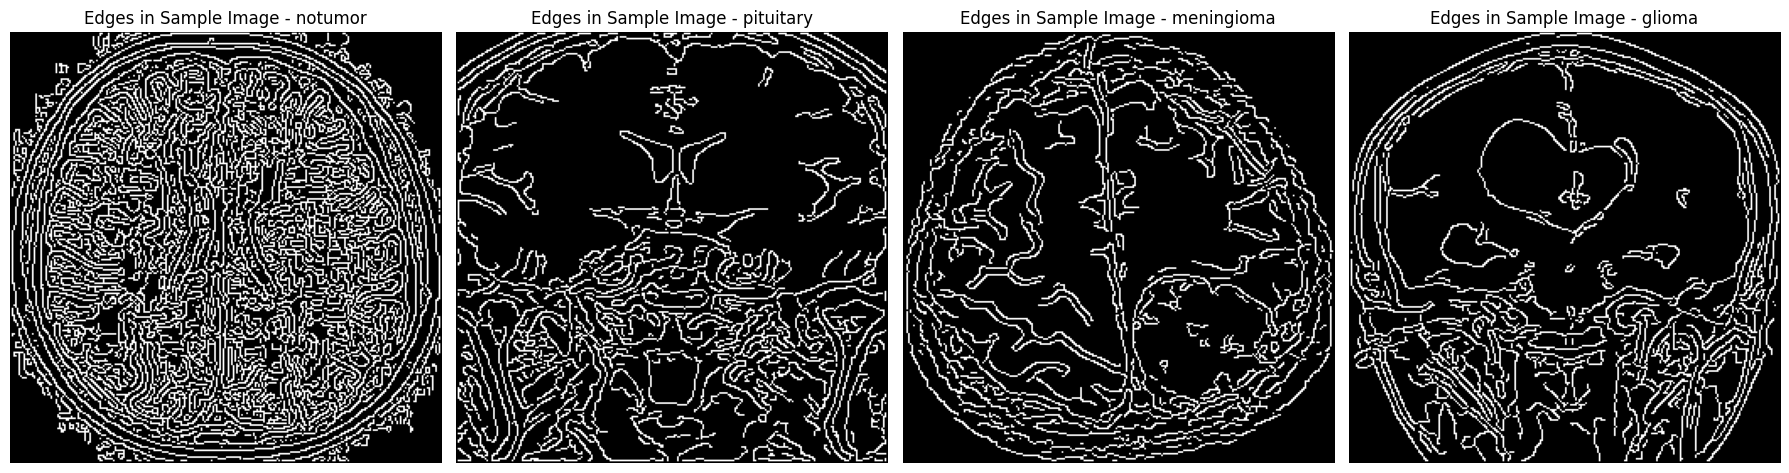

In [41]:
import matplotlib.pyplot as plt
# Display edges for one sample image per class
fig, axes = plt.subplots(1, len(labels), figsize=(18, 6))
for idx, label in enumerate(labels):
    class_path = cleaned_train_dir / label
    sample_img_path = next(class_path.glob('*.jpg'))  # Pick the first image from each class
    with Image.open(sample_img_path).convert("L") as img:
        img_array = np.array(img)
        edges = feature.canny(img_array, sigma=1)  # Apply edge detection (Canny)
        axes[idx].imshow(edges, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"Edges in Sample Image - {label}")
plt.tight_layout()
plt.show()

This is interesting and shows more of the brain structure, with the higly folded structure. We can see that some perspectives of the MRI scans have much fewer edges. Overall, after running the above cell with other image samples, we became confident that the pre-processing did not introduce artifacts. To the untrained eye, we could not discern possible features of tumors, besides that they look like "out-of-place" blobs in the image.

**Remark**: The previous cell can be rerun to check more images. Python's `glob` iterates through files in an arbitrary order. Each time the script is run, `next` will pick the "first" image according to this order, which may change depending on the underlying file system or how files were added to the directory.

# 2.5 Dimensionality reduction 

## Randomised PCA

To do further analysis of our dataset, we reduce its dimensionality using randomized Principal Component Analysis (PCA). Randomized PCA [16] approximates the first $k$ principal components efficiently by using random projections to map the data to a lower-dimensional subspace (see VivekP/03-EDA.ipynb for further details). This approach is both faster and more scalable [17] than traditional PCA, making it suitable for large datasets. In our case, each 256 x 256 image is encoded as a $256^2 = 65536$ dimensional vector and so randomised PCA has noticeable benefits.  We apply randomized PCA to extract the first two principal components, which we plot against each other to reveal key patterns and relationships in the dataset.

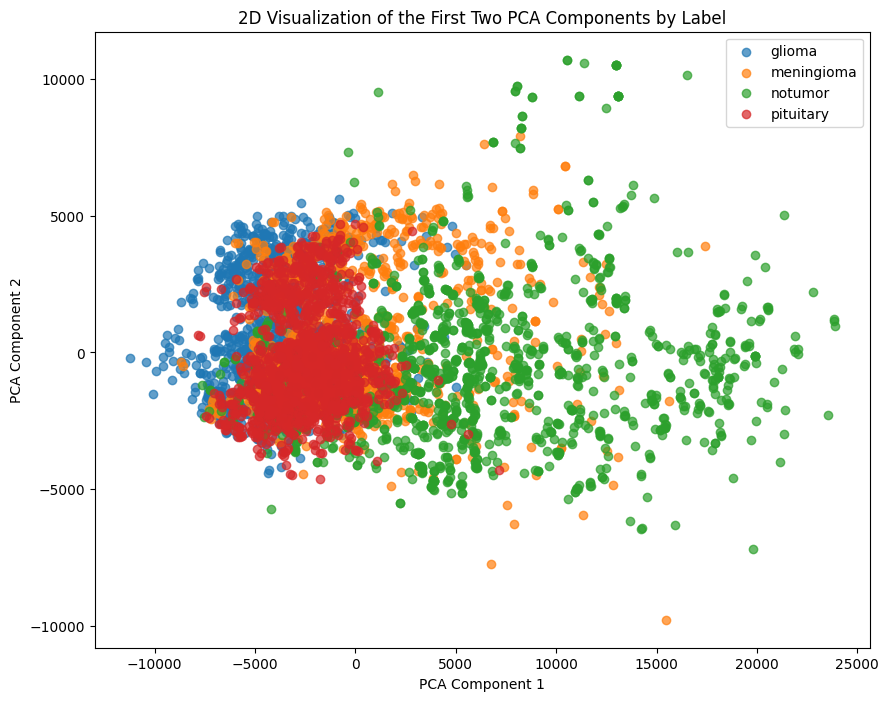

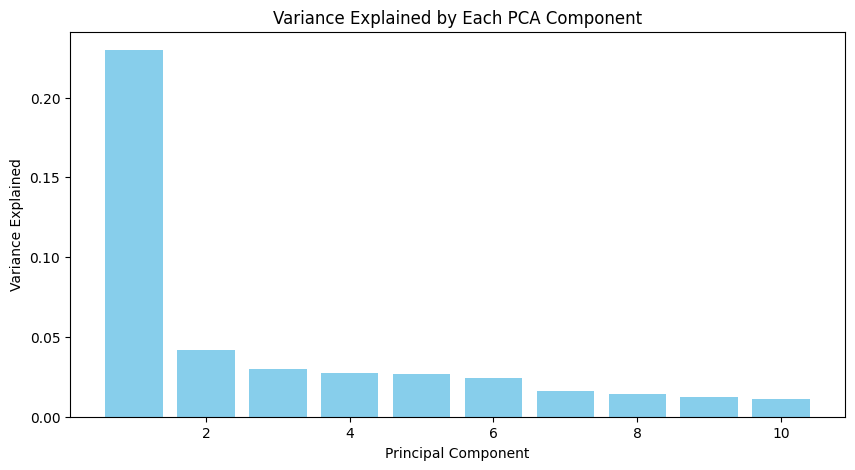

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
from PIL import Image

# Define path and labels
cleaned_train_dir = Path("cleaned/Training")
labels = [label.name for label in cleaned_train_dir.iterdir() if label.is_dir()]

# Load images without resizing and flatten them
images = []
image_labels = []

for label in labels:
    class_path = cleaned_train_dir / label
    for image_file in class_path.glob('*.jpg'):
        with Image.open(image_file).convert("L") as img:
            img_array = np.array(img).flatten()  # Flatten image without resizing
            images.append(img_array)
            image_labels.append(label)

# Convert images to a numpy array
images = np.array(images)

# Apply Randomized PCA to reduce to 10 components
pca = PCA(n_components=10, svd_solver="randomized", random_state=42)
images_pca = pca.fit_transform(images)

# Plot the first two PCA components
plt.figure(figsize=(10, 8))
for label in np.unique(image_labels):
    idx = np.where(np.array(image_labels) == label)
    plt.scatter(images_pca[idx, 0], images_pca[idx, 1], label=label, alpha=0.7)
plt.legend()
plt.title("2D Visualization of the First Two PCA Components by Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Optional: Plot explained variance to understand the importance of each component
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), pca.explained_variance_ratio_, color="skyblue")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Variance Explained by Each PCA Component")
plt.show()


The no-tumour points are separated away from the others, potentially being due to the fact that they won't have "out-of-place" blobs (the tumours). On the other hand, the tumor classes all overlap significantly, matching what we thought about that the untrained eye cannot distinguish between them easily. We do see some differences in the size and spread of the tumour "blobs".

The PCA components themselves are hard to interpret visually; they don’t correspond directly to specific visual features. However, they do represent combinations of features (such as grayscale intensity patterns) that vary the most across the dataset. Most of the variance in the data is explained by the first principal component (PC1), and the next 5 principal components have about the same amount of variance explained each (with PC2 having slightly higher explained variance out of PC2-PC6). 

To glean further insights and ensure we were not missing anything, we used another dimensionality reduction technique called t-stochastic neighbour embeddings (t-SNE).

## t-stochastic neighbourhood embedding
Stochastic neighbourhood methods (Hinton et al. 2002 [18], van der Maaten et al. 2008 [20]) rely upon a connection between distances in the two spaces. To explain the central idea, suppose we wish to transform $\{x_1, . . . , x_n\}$ to a
low-dimensional representation $\{z_1, . . . , z_n\}$. Then, for each pair of examples $(i, j) \in \{1, \ldots, n\}$, there is a corresponding probability
$p_{ij}$ which is large when $x_j$ is relatively close to $x_i$ and small otherwise. These probabilities are matched with associated probabilities $q_{ij}$ which is large when $z_j$ is relatively close to $z_i$ and small otherwise.
Gradient based learning is then used to move around the points $\{z_1, \ldots, z_n\}$ to optimise the probability.

The t-stochastic neighbourhood embedding (t-SNE) [20] builds
upon the original stochastic neighbourhood idea by using a t-distribution for the representation space $\mathbb{R}^k$ and Gaussian distributions in the high-dimensional space $\mathbb{R}^p$.  We explain further details on how this algorithm works in VivekP/03-EDA.ipynb, including advantages and disadvantages. The key difference is that $t$-SNE is a non-linear method, and we hope that this helps us understand if there are some structural features in the data that were not elucidated by the PCA plot.

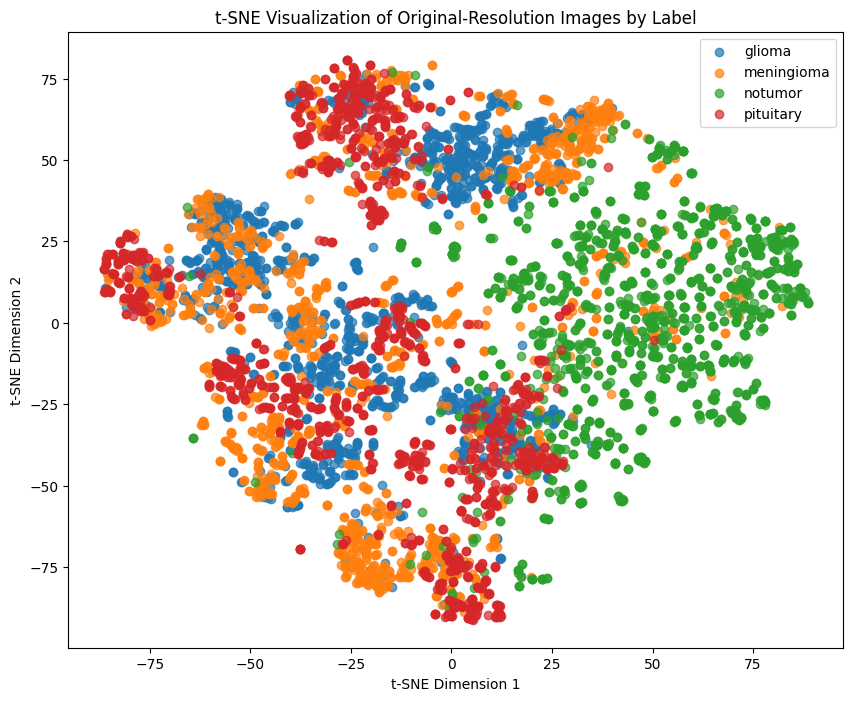

In [43]:
# Apply Randomized PCA (to 50 components because 10 didn't work)
pca = PCA(n_components=50, svd_solver="randomized", random_state=42)
images_pca = pca.fit_transform(images)

# Apply t-SNE on the PCA-transformed data for 2D visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
images_tsne = tsne.fit_transform(images_pca)

# Plot the results
plt.figure(figsize=(10, 8))
for label in np.unique(image_labels):
    idx = np.where(np.array(image_labels) == label)
    plt.scatter(images_tsne[idx, 0], images_tsne[idx, 1], label=label, alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Original-Resolution Images by Label")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


This gives a much better separation of the classes. We can see that the `notumor` class is well separated (being to the "East" in the plot) to the others. There is a "North", "West" and "South" blob, consisting of patches of colours of red, blue and orange. The best separation of the patches of colours is in the "North" blob, with the other blobs having more overlap. The presence of the "North", "West" and "South" blobs could potentially be the **angle** of the MRI images (front, back and side views) being revealed as a form of structure in the dataset. Such an observation would corroborate previous analyses done of this dataset (see [21]).

Overall, this plot provides us with insights and reassurance that a model could learn some of this structure we have revealed to perform the classification.



# 3. Conclusion

In this document, we have performed detailed EDA on this dataset. We looked at the following:

- Class distributions: These were balanced and so there is no need to use a technique for imbalanced data here. This allows us to focus on the techincal question of our choice: to understand how the neural net is affected by its parameters.
- Image preprocessing: The images were not the same size. Some were grayscale and some were in color. We therefore did preprocessing to standardise the images. 
- Image visualisation: We looked at the images, before and after preprocessing. We visualised quantities such as brightness, contrast and entropy to understand the differences between the images on a quantitative level. This was followed by using the Canny edge detection algorithm to check that the preprocessing did not leave behind some artifacts.
- Dimensionality reduction: To understand the structure within the dataset, we used randomised PCA and t-SNE. We studied the mathematical details of t-SNE and used this for our dataset.

Overall, we saw that there is underlying structure in the data which can be exploited by a model to perform classification.

# 4. References

[1] Brain tumour MRI dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

[2] Kaggle discussion on finding duplicates: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/discussion/482896

[3] Padding vs Resizing: https://stackoverflow.com/questions/47697622/cnn-image-resizing-vs-padding-keeping-aspect-ratio-or-not/49882055#49882055

[4] Resizing: https://datascience.stackexchange.com/questions/40462/how-to-prepare-the-varied-size-input-in-cnn-prediction

[5] Resizing: https://www.reddit.com/r/computervision/comments/1dda0eq/why_is_the_importance_of_resizing_the_images_why/

[6] OpenCV documentation to understand erosion and dilation: https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html

[7] Medium article on erosion and dilation: https://medium.com/@sasasulakshi/opencv-morphological-dilation-and-erosion-fab65c29efb3

[8] Techniques for dealing with imbalance: https://datasciencedojo.com/blog/techniques-to-handle-imbalanced-data/

[9] VGGNet and ResNet: https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96

[10] Transfer Learning: [Article](https://builtin.com/data-science/transfer-learning#:~:text=Transfer%20learning%2C%20used%20in%20machine,to%20improve%20generalization%20about%20another)

[11] Canny algorithm for Edge Detection: [Article](https://en.wikipedia.org/wiki/Canny_edge_detector)

[12] Article on Contrast: [Article](https://www.olympus-lifescience.com/en/microscope-resource/primer/java/olympusmicd/digitalimaging/contrast/#:~:text=The%20term%20contrast%20refers%20to,than%20those%20of%20lower%20contrast.)

[13] How to compute Contrast: https://dsp.stackexchange.com/questions/3309/measuring-the-contrast-of-an-image

[14] Shannon Entropy: https://en.wikipedia.org/wiki/Entropy_(information_theory)

[15] OpenCV documentation of Canny edge detection: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

[16] Randomised PCA: https://www.geeksforgeeks.org/python-variations-of-principal-component-analysis/

[17] Randomised projections: https://stats.stackexchange.com/questions/235632/pca-vs-random-projection

[18] Stochastic neighbourhood methods: https://papers.nips.cc/paper_files/paper/2002/hash/6150ccc6069bea6b5716254057a194ef-Abstract.html

[19] KL divergence: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

[20] Visualizing data using t-SNE. van der Maaten, G Hinton.
The Journal of Machine Learning Research 9 (2579-2605), 85.

[21] Past Data Science Toolbox project on this dataset: https://github.com/shreyashah24/DST-Assessment-3/blob/main/Report/-02-EDA.ipynb

[22] MLE and KL Divergence: https://jaketae.github.io/study/kl-mle/

[23] Explanation of hashes: [Article](https://www.trendmicro.com/vinfo/gb/security/definition/hash-values#:~:text=Hash%20values%20can%20be%20thought,the%20contents%20of%20the%20file).

[24] Hashing with MD5: https://www.reddit.com/r/cryptography/comments/q5ry44/how_does_md5_work_in_very_simple_terms/

[25] Explanation of MRI: [Hopkins Medicine Article](https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/magnetic-resonance-imaging-mri#:~:text=What%20is%20MRI%3F,large%20magnet%20and%20radio%20waves)

[26] Tumour definition: https://www.cancer.gov/publications/dictionaries/cancer-terms/def/tumor

[27] Image processing for medical diagnosis using CNN - Arena, A Basile, M Bucolo, L Fortuna - Nuclear Instruments and Methods, 2003 - Elsevier.